## Импорт необходимых библиотек

In [ ]:
from numpy.random import normal
from mathtoolbox import *
from viewtoolbox import *

# Если есть желание сделать графики интерактивными (чтобы был зум и перемещение), 
# снимите комментарий с одной из следующих строчек:
# %matplotlib widget  
# %matplotlib qtagg

## Моделирование случайной величины с заданной корреляционной функцией

### Исходные параметры (константы)

$\bullet$ Интервал времени, на котором рассматтривается корреляция (мкс) - TIME_WINDOW_US};

$\bullet$ Частота дискретизации (МГц), ${f_d}$ - F_SAMPLING_MHZ;

$\bullet$ Среднеквадратичное отклонение (СКО), $\sigma$ - SIGMA_NORMAL;

$\bullet$ Математическое ожидаение, $m$ - MU_PARAM;

$\bullet$ Число усредняемых реализаций - N_SAMPLES.

In [2]:
# Параметры моделирования и распределения
TIME_WINDOW_US = 300    # временной интервал, на котором рассматривается корреляция, мкс
F_SAMPLING_MHZ = 20     # частота дискретизации, МГц
SIGMA_NORMAL = 11       # СКО гауссовского случайного процесса
MU_PARAM = 0            # мат. ожидание исходного процесса
N_SAMPLES = 20          # число усредняемых реализаций

### Формирование некоррелированного случайного процесса

*Исходный некоррелированный (белый) гауссовский шум:*

In [3]:
N_COUNTS = int(TIME_WINDOW_US*F_SAMPLING_MHZ)   # число отсчетов
X = normal(MU_PARAM, SIGMA_NORMAL, (N_SAMPLES, N_COUNTS))   # исходный СП (гауссовский СП)

*Отображение плотности вероятности исходного процесса:*

Функция идеальной гауссовой плотности вероятности имеет следующий вид:
$$w(x) = \frac{1}{\sqrt{2\pi}\sigma} \cdot e^{-\frac{(x - m)^2}{2\sigma^2}}.$$
При этом, огибающая гистограммы полученных отсчётов исходной реализации должна сходиться к идеальному случаю.

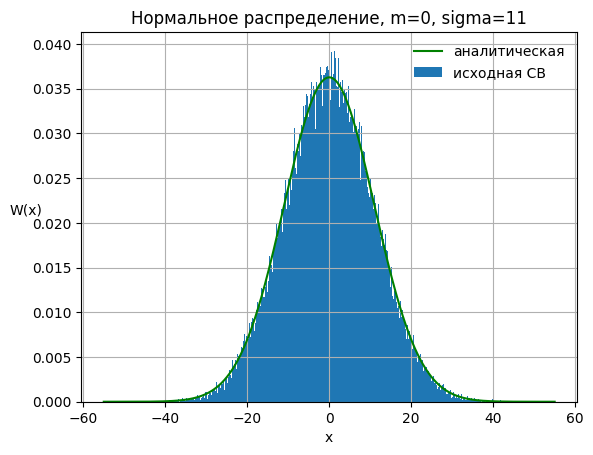

In [4]:
x_axis = np.linspace(-5*SIGMA_NORMAL, 5*SIGMA_NORMAL, 1000) # интервал значений, на котором задана плотность вероятноси
# Идеальная плотность вероятности исходного закона распределения
w_x = 1/(np.sqrt(2*np.pi)*SIGMA_NORMAL) * np.exp(-(x_axis-MU_PARAM)**2 / (2*SIGMA_NORMAL**2))

plot_distrib_with_analyt(X, x_axis, w_x, 'Нормальное распределение, m=' + str(MU_PARAM) + ', sigma=' + str(SIGMA_NORMAL))

*Корреляционная функция исходного СП:*

Для дискретного нормированного белого гауссовского шума корреляционная функция имеет вид:
$$
R[k] = 
\begin{cases}
1, k = 0 \\
0, k \neq 0 
\end{cases}
$$

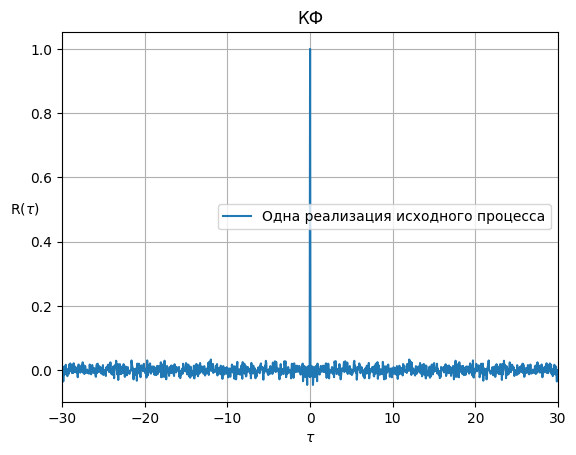

In [5]:
rx_sample, rx_est = calculate_correlate(X, N_COUNTS, N_SAMPLES)

plot_corr_func([[rx_sample, 'Одна реализация исходного процесса']], TIME_WINDOW_US, N_COUNTS, TIME_WINDOW_US/10)

*Спектральная плотность мощности (СПМ) исходного процесса:*

СПМ дискретного белого гауссовского шума имеет постоянное значение:
$$S(\omega) = S_0.$$

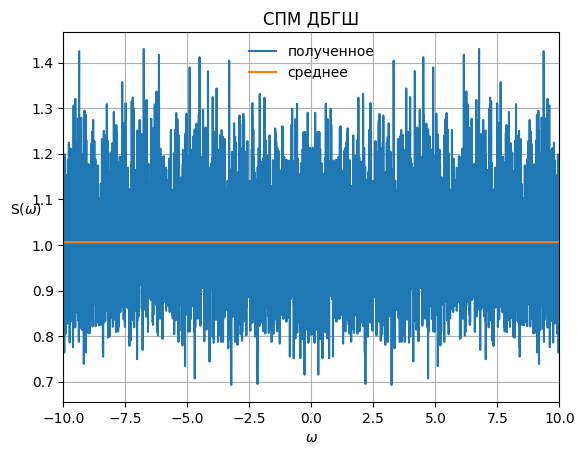

In [6]:
plot_SPD_DNWGN(rx_est, F_SAMPLING_MHZ, N_COUNTS)

### Формирование коррелированного случайного процесса

**Моделирование СП с экспоненциальной функцией корреляции**

*Корреляционная функция процесса:*

Целевая корреляционная функция имеет вид:
$$R(\tau) = e^{-2\frac{|\tau|}{l}},$$
где $l$ - интервал корреляции, оцениваемый следующим образом:
$$R(\tau = l) ≈ 0,14.$$

In [ ]:
ex_corr_int = 10    # интеравал корреляции, мкс
r_fun_ex : Callable[[np.ndarray, int | float], np.ndarray] = lambda x, corr: np.exp(-2 * abs(x) / corr)  # КФ

*Получение отсчетов теоретической КФ для двух различных интервалов корреляции:*

In [ ]:
# Теоретическая КФ
r_fun_l1_ex = get_corr_func(r_fun_ex, ex_corr_int, TIME_WINDOW_US, N_COUNTS)  # на заданном по варианту интервале корреляции
r_fun_l2_ex = get_corr_func(r_fun_ex, 2*ex_corr_int, TIME_WINDOW_US, N_COUNTS)    # на удвоенном интервале корреляции

*Реализации коррелированного шума на двух различных интервалах корреляции:*

In [ ]:
y_l1_ex = apply_corr_filter(X, TIME_WINDOW_US, r_fun_ex, ex_corr_int)    # коррелированный СП на заданном по варианту интервале корреляции
y_l2_ex = apply_corr_filter(X, TIME_WINDOW_US, r_fun_ex, 2*ex_corr_int)    # коррелированный СП на удвоенном интервале корреляции

*Отображение плотности вероятности полученного коррелированного процесса:*

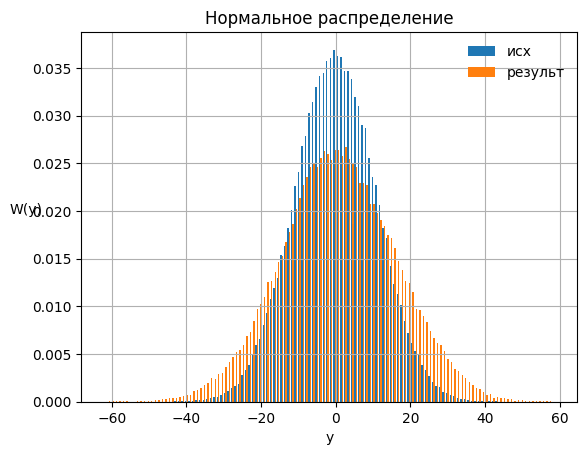

In [ ]:
# Плотность распределения коррелированного процесса
plot_distrib([[X, 'исх'], [y_l1_ex, 'результ']], title='Нормальное распределение')

*Получение экспериментальной КФ:*

In [ ]:
ry_sample_l1_ex, ry_est_l1_ex = calculate_correlate(y_l1_ex, N_COUNTS, N_SAMPLES) # КФ для заданного по варианту интервалу корреляции
ry_sample_l2_ex, ry_est_l2_ex = calculate_correlate(y_l2_ex, N_COUNTS, N_SAMPLES) # КФ для удвоенного интервала корреляции

*Отображение полученных КФ:*

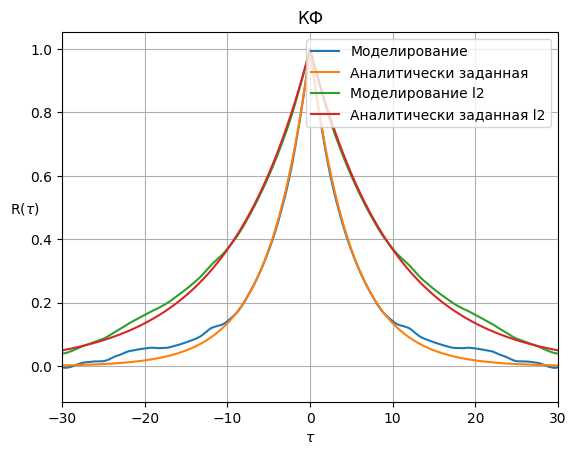

In [ ]:
plot_corr_func([[ry_est_l1_ex, 'Моделирование'],
                [r_fun_l1_ex, 'Аналитически заданная'],
                [ry_est_l2_ex, 'Моделирование l2'],
                [r_fun_l2_ex, 'Аналитически заданная l2']],
                TIME_WINDOW_US,
                N_COUNTS,
                3*ex_corr_int)

*СПМ полученного процесса:*

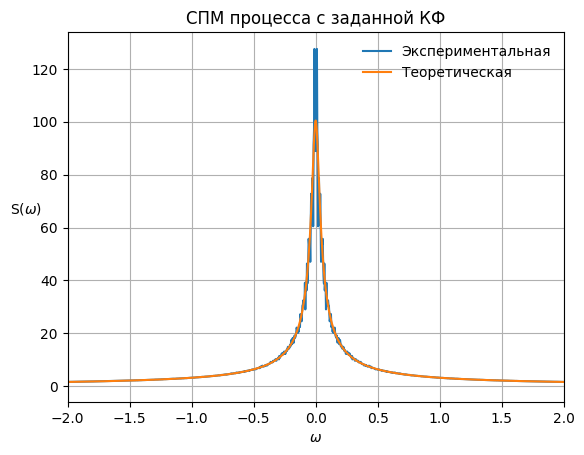

In [ ]:
# СПМ процесса с заданной КФ
plot_SPD([[ry_est_l1_ex, 'Экспериментальная'], 
          [r_fun_l1_ex, 'Теоретическая']], 
          F_SAMPLING_MHZ,
          N_COUNTS, 
          0.1*F_SAMPLING_MHZ)

**Моделирование СП с корреляционной функцией, заданной по варианту**

Выполнить моделирование СП с КФ, заданной по варианту, при двух разных интервалах корреляции:
$$ l_1 = l; $$
$$ l_2 = 2 \cdot l. $$

Для этого необходимо выполнить следующее:

$ \bullet $ Задать интервал корреляции (мкс), соответствующий Вашему варианту;

$ \bullet $ Реализовать функцию, соответствующую заданной по варианту КФ, на вход которой поступает два параметра: массив отстройки КФ и интервал корреляции (можно реализовать через lambda-функцию или через def);

$ \bullet $ Получить отсчеты коррелированного шума;

$ \bullet $ Отобразить:<br>
$ \hspace{1cm} - $ плотность вероятности полученного процесса,<br> 
$ \hspace{1cm} - $ теоретическую КФ и КФ полученного процесса при двух различных интервалах корреляции (на одном графике),<br> 
$ \hspace{1cm} - $ теоретическую СПМ и СПМ полученного процесса (на одном графике).

*Корреляционная функция процесса:*

In [ ]:
corr_int_us = ...   # интервал корреляции, мкс
r_func = ...    # КФ

*Получение отсчетов теоретической КФ для двух различных интервалов корреляции:*

*Реализации коррелированного шума на двух различных интервалах корреляции:*

*Отображение плотности вероятности полученного коррелированного процесса:*

*Получение экспериментальной КФ:*

*Отображение полученных КФ:*

*СПМ полученного процесса:*